In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

### Importazione dataframe

In [2]:
df1 = pd.read_csv('C:/Users/HP/Desktop/PLC_gualchierani/monitorconi_23mar_to_29mar.csv')
df2 = pd.read_csv('C:/Users/HP/Desktop/PLC_gualchierani/monitorconi_30mar_to_4apr.csv')
df3 = pd.read_csv('C:/Users/HP/Desktop/PLC_gualchierani/monitorconi_5apr_to_11apr.csv')

df1["measured_at"] = pd.to_datetime( df1["measured_at"] )
df2["measured_at"] = pd.to_datetime( df2["measured_at"] )
df3["measured_at"] = pd.to_datetime( df3["measured_at"] )

mask_30mar = np.asarray( df1[ df1['measured_at'].dt.day == 30].index )
df1.drop( mask_30mar, inplace = True )

mask_29mar = np.asarray( df2[ df2['measured_at'].dt.day == 29].index )
df2.drop( mask_29mar, inplace = True )

mask_5apr = np.asarray( df2[ df2['measured_at'].dt.day == 5].index )
df2.drop( mask_5apr, inplace = True )

mask_4apr = np.asarray( df3[ df3['measured_at'].dt.day == 4].index )
df3.drop( mask_4apr, inplace = True )

mask_12apr = np.asarray( df3[ df3['measured_at'].dt.day == 12].index )
df3.drop( mask_12apr, inplace = True )

df = pd.concat([df1,df2, df3])

In [3]:
df.drop(['id', 'tipologia_lavorazione', 'cicli_da_eseguire',
        'cicli_eseguiti', 'tempo_miscelazione_eseguito',
        'stato_tramoggia', 'tara_cono', 'lotto',
        'created_at', 'updated_at'], axis=1, inplace=True)

In [4]:
mask_no_cono = np.asarray( df[ df['id_cono'] > 24 ].index )
df.drop( mask_no_cono, inplace = True )

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 816645 entries, 0 to 528311
Data columns (total 9 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   id_cono                           816645 non-null  int64         
 1   ubicazione                        816645 non-null  int64         
 2   stato                             816645 non-null  int64         
 3   postazione_pesatura_destinazione  816645 non-null  int64         
 4   miscelatore_destinazione          816645 non-null  int64         
 5   estrusore_destinazione            816645 non-null  int64         
 6   tempo_miscelazione_richiesto      816645 non-null  int64         
 7   destinazione_ritorno              816645 non-null  int64         
 8   measured_at                       816645 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(8)
memory usage: 62.3 MB


In [55]:
df['estrusore_destinazione'].unique()

array([4, 5, 1, 2, 3, 8, 6, 0, 9], dtype=int64)

### Preparazione dati di supporto

In [7]:
buffer = [n for n in range(21, 29)]
buffer.extend([n for n in range(31, 39)])

legenda_gualchierani = {
    'fuori_impianto': [0],
    'ing_zona_misc': [1],
    'catenaria_ing_misc': [45, 46],
    'navetta_serv_misc': [43],
    'pesatura': [41, 42],
    'miscelatore': [2, 8],
    'cat_usc_pieni': [3],
    'nav_serv_carr_pieni': [4],
    'nav_serv_carr_vuoti': [5],
    'buffer': buffer,
    'carroponte_1': [6],
    'carroponte_2': [7],
    'estrusore': [n for n in range(11, 19)],
    'handling_post_est': [6, 5, 4],
    'catenaria_vuoti': [47, 48],
    'catenaria_uscita_vuoti': [49],
    'pinza_vuoti': [50],
    'catenaria_parcheggi': [n for n in range(51, 58)],
    'nav_serv_parcheggi': [44],
    'manuale': [68, 70]
}

dict_states = {
    0: 'Not_def',
    1: 'V_per_park',
    2: 'P_da_misc',
    3: 'P_da_est',
    4: 'P_remove',
    5: 'P_recheck',
    6: 'P_per_park',
    7: 'V_da_pes',
    8: 'V_remove',
    9: 'V_lavaggio'
}

starter = ['V_da_pes/nav_serv_carr_pieni', 'V_da_pes/nav_serv_carr_vuoti',
'V_da_pes/catenaria_vuoti', 'V_da_pes/catenaria_parcheggi',
'V_da_pes/nav_serv_parcheggi', 'V_da_pes/catenaria_ing_misc',
'V_da_pes/ing_zona_misc']

finisher = ['P_da_est/estrusore', 'Not_def/fuori_impianto']

finisher2 = ['V_per_park/estrusore', 'V_da_pes/estrusore', 'Not_def/fuori_impianto']

### Preparazione funzioni

In [8]:
#  questa funzione estrae dal df il primo record in ordine temporale per ogni ubicazione

def create_df_t_new(df, cono_in_esame):
    mask = df['id_cono'] == cono_in_esame
    df1 = df[mask]

    ubicazione = []
    stato = []
    timestamp = []
    stazione = []
    miscelatore = []
    for i in range(1, len(df1) - 1):
        if df1.iloc[i, 1] in legenda_gualchierani['pesatura']:
            if (df1.iloc[i, 1] != df1.iloc[i - 1, 1]) or (df1.iloc[i, 1] != df1.iloc[i + 1, 1]):
                ubicazione.append(df1.iloc[i, 1])
                stato.append(df1.iloc[i, 2])
                timestamp.append(df1.iloc[i, 8])
                stazione.append(df1.iloc[i, 3])
                miscelatore.append(df1.iloc[i, 4])
        elif df1.iloc[i, 1] in legenda_gualchierani['miscelatore']:
            if (df1.iloc[i, 1] != df1.iloc[i - 1, 1]) or (df1.iloc[i, 1] != df1.iloc[i + 1, 1]):
                ubicazione.append(df1.iloc[i, 1])
                stato.append(df1.iloc[i, 2])
                timestamp.append(df1.iloc[i, 8])
                stazione.append(df1.iloc[i, 3])
                miscelatore.append(df1.iloc[i, 4])
        else:
            continue

#  estrae i valori dalla memoria del PLC li traduco in parole
    for i in range(len(ubicazione)):
        for k,v in legenda_gualchierani.items():
            if ubicazione[i] in v:
                ubicazione[i] = k

    for i in range(len(stato)):
        stato[i] = dict_states[stato[i]]

#  crea il dataframe che sarà input alla funzione di individuazione della tracce
    df_t = pd.DataFrame(list(zip(stato, ubicazione, timestamp, stazione, miscelatore)),
                        columns =['stato', 'ubicazione', 'timestamp', 'stazione', 'miscelatore'])
    df_t.sort_values('timestamp', inplace=True)
    df_t['rif'] = (df_t.stato.astype('str') + '/' + df_t.ubicazione.astype('str'))
    df_t.drop_duplicates(inplace=True)
    return(df_t)

### Calcolo tracce

In [9]:
trace = 0
for c in range(1, 25):
    start = datetime.now()
    if c == 1:
        df_pes = create_df_t_new(df, c)
    else:
        df_pes = pd.concat([df_pes, create_df_t_new(df, c)])
    end = datetime.now()
    print('TEMPO ELABORAZIONE CONO {} {}'.format(c, end-start))

TEMPO ELABORAZIONE CONO 1 0:00:06.715682
TEMPO ELABORAZIONE CONO 2 0:00:05.734397
TEMPO ELABORAZIONE CONO 3 0:00:04.149145
TEMPO ELABORAZIONE CONO 4 0:00:04.812118
TEMPO ELABORAZIONE CONO 5 0:00:04.342555
TEMPO ELABORAZIONE CONO 6 0:00:05.267633
TEMPO ELABORAZIONE CONO 7 0:00:04.509371
TEMPO ELABORAZIONE CONO 8 0:00:06.534477
TEMPO ELABORAZIONE CONO 9 0:00:07.173232
TEMPO ELABORAZIONE CONO 10 0:00:06.920803
TEMPO ELABORAZIONE CONO 11 0:00:06.250492
TEMPO ELABORAZIONE CONO 12 0:00:06.609714
TEMPO ELABORAZIONE CONO 13 0:00:07.500101
TEMPO ELABORAZIONE CONO 14 0:00:05.812887
TEMPO ELABORAZIONE CONO 15 0:00:05.563189
TEMPO ELABORAZIONE CONO 16 0:00:07.110202
TEMPO ELABORAZIONE CONO 17 0:00:06.625053
TEMPO ELABORAZIONE CONO 18 0:00:05.554011
TEMPO ELABORAZIONE CONO 19 0:00:05.422316
TEMPO ELABORAZIONE CONO 20 0:00:05.139849
TEMPO ELABORAZIONE CONO 21 0:00:05.502162
TEMPO ELABORAZIONE CONO 22 0:00:04.475188
TEMPO ELABORAZIONE CONO 23 0:00:06.672195
TEMPO ELABORAZIONE CONO 24 0:00:06.222111


In [10]:
df_pes.reset_index(drop=True, inplace=True)
df_pes['ID'] = 0
idu = 0
for i in df_pes.index:
    if (df_pes.loc[i, 'rif'] == 'V_da_pes/pesatura' and df_pes.loc[i + 1, 'rif'] == 'P_da_misc/pesatura'):
        df_pes.loc[i, 'ID'] = idu
        df_pes.loc[i + 1, 'ID'] = idu
        idu += 1
        continue
    if (df_pes.loc[i, 'rif'] == 'P_da_misc/miscelatore' and df_pes.loc[i + 1, 'rif'] == 'P_da_est/miscelatore'):
        df_pes.loc[i, 'ID'] = idu
        df_pes.loc[i + 1, 'ID'] = idu
        idu += 1
        continue
        

In [11]:
staz_1 = []
staz_2 = []
misc_1 = []
misc_2 = []

for i in df_pes['ID'].unique():
    df_tmp = df_pes[ df_pes['ID'] == i ]
    df_tmp.reset_index(inplace=True, drop=True)
    dt = df_tmp.loc[1, 'timestamp'] - df_tmp.loc[0, 'timestamp']
    
    if df_tmp.loc[0, 'ubicazione'] == 'pesatura':
        if df_tmp.loc[0, 'stazione'] == 1:
            staz_1.append(dt)
        else:
            staz_2.append(dt)
    elif df_tmp.loc[0, 'ubicazione'] == 'miscelatore':
        if df_tmp.loc[0, 'miscelatore'] == 1:
            misc_1.append(dt)
        else:
            misc_2.append(dt)

In [12]:
print('Tempo medio di dosatura stazione 1: ', np.mean(staz_1))
print('Tempo medio di dosatura stazione 2: ', np.mean(staz_2))
print('Tempo medio di miscelatore 1: ', np.mean(misc_1))
print('Tempo medio di miscelatore 2: ', np.mean(misc_2))

Tempo medio di dosatura stazione 1:  0 days 00:28:28.657777777
Tempo medio di dosatura stazione 2:  0 days 00:10:45.659949622
Tempo medio di miscelatore 1:  0 days 00:03:36.904069767
Tempo medio di miscelatore 2:  -1 days +23:21:24.512295082


In [13]:
tot_staz_1 = sum([x.total_seconds() / 60 for x in staz_1])
tot_staz_2 = sum([x.total_seconds() / 60 for x in staz_2])
tot_misc_1 = sum([x.total_seconds() / 60 for x in misc_1])
tot_misc_2 = sum([x.total_seconds() / 60 for x in misc_2])

tot_staz = tot_staz_1 + tot_staz_2
tot_misc = tot_misc_1 + tot_misc_2

In [14]:
print('Saturazione stazione 1 su tot stazioni: ', tot_staz_1 / tot_staz * 100, '%')
print('Saturazione stazione 2 su tot stazioni: ', tot_staz_2 / tot_staz * 100, '%')
print('Saturazione miscelatore 1 su tot miscelatori: ', tot_misc_1 / tot_misc * 100, '%')
print('Saturazione miscelatore 2 su tot miscelatori: ', tot_misc_2 / tot_misc * 100, '%')

Saturazione stazione 1 su tot stazioni:  59.99734696266247 %
Saturazione stazione 2 su tot stazioni:  40.002653037337524 %
Saturazione miscelatore 1 su tot miscelatori:  -7.070213191351036 %
Saturazione miscelatore 2 su tot miscelatori:  107.07021319135104 %


In [15]:
days = df['measured_at'].dt.day.unique()

In [30]:
tot_min = 0
for d in days:
    df_day = df[(df['measured_at'].dt.day == d) & (df['ubicazione'].isin([41, 42]))]
    df_day.sort_values('measured_at', inplace=True)
    df_day.reset_index(inplace=True, drop=True)
    if len(df_day) != 0:
        dt = df_day.loc[len(df_day) - 1, 'measured_at'] - df_day.loc[0, 'measured_at']
        tot_min += dt.total_seconds() / 60

In [31]:
tot_min / 60

362.66833333333335

In [35]:
tot_h = (48) * 7.5
tot_min = tot_h * 60

In [36]:
print('Saturazione stazione 1: ', tot_staz_1 / tot_min * 100, '%')
print('Saturazione stazione 2: ', tot_staz_2 / tot_min * 100, '%')
print('Saturazione miscelatore 1: ', tot_misc_1 / tot_min * 100, '%')
print('Saturazione miscelatore 2: ', tot_misc_2 / tot_min * 100, '%')

Saturazione stazione 1:  59.328395061728415 %
Saturazione stazione 2:  39.556635802469025 %
Saturazione miscelatore 1:  5.757330246913569 %
Saturazione miscelatore 2:  -87.1881172839507 %


In [38]:
len(df_pes[df_pes['rif'] == 'V_da_pes/pesatura'])

1652

In [39]:
coni_h = len(df_pes[df_pes['rif'] == 'V_da_pes/pesatura']) / tot_h
coni_day = int(coni_h * 24)

In [40]:
print('Coni dosati per ora: ', coni_h)
print('Coni dosati per giorno: ', coni_day)

Coni dosati per ora:  4.588888888888889
Coni dosati per giorno:  110


### Calcolo tempi di interarrivo

In [41]:
df_int = df_pes[df_pes['rif'] == 'V_da_pes/pesatura']

In [42]:
df_int.sort_values('timestamp', inplace=True)
df_int.reset_index(drop=True, inplace=True)

In [43]:
intervals = []

for i in range(len(df_int) - 1):
    time_delta = df_int.loc[i + 1, 'timestamp'] - df_int.loc[i, 'timestamp']
    dt = time_delta.total_seconds() / 60
    intervals.append(dt)

In [44]:
len(intervals) / tot_h

4.586111111111111

In [27]:
from fitter import Fitter, get_common_distributions, get_distributions
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
def quantile2(column,pct,pct_lower):
    y = column
    y.sort()
    len_y = len(y)
    y = y[int(pct_lower * len_y):int(len_y * pct)]
    return y

In [28]:
intervals = quantile2(intervals,0.999,0)

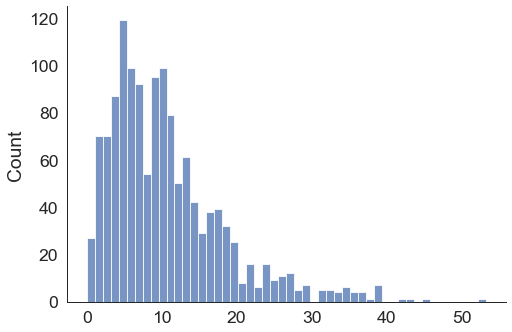

In [29]:
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
sns.displot(data=intervals, kind="hist", bins = 50, aspect = 1.5)

C:\Users\HP\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1826: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]
C:\Users\HP\anaconda3\lib\site-packages\scipy\integrate\quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=se

,sumsquare_error,aic,bic,kl_div
burr12,0.009254,1067.089519,-15855.923497,inf
exponweib,0.009295,1073.644866,-15850.008464,inf
gengamma,0.009312,1074.932150,-15847.609918,inf
beta,0.009313,1075.445007,-15847.447858,inf
pearson3,0.009314,1073.311376,-15854.530131,inf


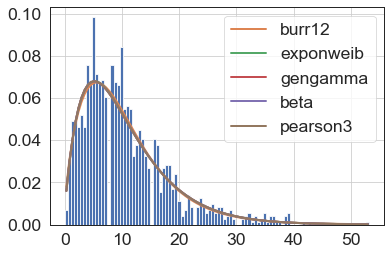

In [30]:
#  extract best fitting distribution
f = Fitter(intervals)
f.fit()
f.summary()

In [31]:
f.get_best(method = 'sumsquare_error')

{'burr12': {'c': 1.6510761870773936,
  'd': 4.90409753998643,
  'loc': -0.139633281979239,
  'scale': 28.18319121005929}}